# Datagnosis Tutorial 02 - image data

*If you prefer, this tutorial is also available on [google colab](https://colab.research.google.com/drive/1QhCLNSYc69Kw-dcmIwD0uCR6TAAiR_us?usp=sharing).*

In this tutorial we will see how to use "hardness characterization method" plugins to calculate the hardness scores for images. We will also plot these values and extract some data points based on these scores. For this tutorial we will be using the cifar and mnist datasets from pytorch.

OK, Lets start!

First we import our logger from datagnosis and set the logging level at "INFO". If something goes wrong and you want to see more detailed logs, you can change the logging level to "DEBUG" or, conversely, if you don't want to see any logs you can remove them with log.remove().

In [1]:
import sys

import datagnosis.logger as log
log.add(sink=sys.stderr, level="INFO")


Load the Image COVID19 dataset. Set the value of the `dataset` variable to select which one you'd like to use.

In [2]:
import torch
from datagnosis.utils.datasets.images.mnist import load_mnist
from datagnosis.utils.datasets.images.cifar import load_cifar

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = "cifar"
model_name = "LeNet"

if dataset == "mnist":
    X_train, y_train, X_test, y_test = load_mnist()
elif dataset == "cifar":
    X_train, y_train, X_test, y_test = load_cifar()
else:
    raise ValueError("Invalid dataset!")

Files already downloaded and verified
Files already downloaded and verified


The next key step is to then pass the data to the DataHandler object provided by Datagnosis. This is done by passing the features and the labels separately. The features can be a `pandas.DataFrame`, `numpy.ndarray` or `torch.Tensor`. The labels can be `pandas.series`, `numpy.ndarray` or `torch.Tensor`.

Here we've limited the number of examples to reduce training time. If the `[:100]`s are removed it will load the whole dataset. This will affect fitting times. Why not play around with the size of the dataset you pass to the DataHandler and see how that affects the results!

In [3]:
from datagnosis.plugins.core.datahandler import DataHandler
# Lets just use the first 100 examples from the dataset
datahandler = DataHandler(X_train[:100], y_train[:100], batch_size=64)

Now we define some values which we will pass to the plugin, such as the model that we want to use to classify the data.

In [4]:

import datagnosis.plugins.core.models.image_nets as im_nets

import torch
import torch.nn as nn

# Instantiate the neural network 
if dataset == 'cifar':
    if model_name == 'LeNet':
        model = im_nets.LeNet(num_classes=10).to(DEVICE)
    if model_name == 'ResNet':
        model = im_nets.ResNet18().to(DEVICE)
elif dataset == 'mnist':
    if model_name == 'LeNet':
        model = im_nets.LeNetMNIST(num_classes=10).to(DEVICE)
    if model_name == 'ResNet':
        model = im_nets.ResNet18MNIST().to(DEVICE)


# creating our optimizer and loss function object
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)



Import the `Plugins` object from Datagnosis. Then by calling `list()` on the we can see all the available plugins that we can use.

In [5]:
# datagnosis absolute
from datagnosis.plugins import Plugins

Plugins().list()


['conf_agree',
 'prototypicality',
 'aum',
 'grand',
 'data_iq',
 'el2n',
 'allsh',
 'confident_learning',
 'data_maps',
 'large_loss',
 'vog',
 'forgetting']

Now we can call `get()` to load up a specific plugin from the list and then we call `fit()`  to fit the plugin.

In [6]:

hcm = Plugins().get(
    "data_iq",
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    lr=learning_rate,
    epochs=2,
    num_classes=10,
    logging_interval=1,
)
hcm.fit(
    datahandler=datahandler,
)

[2023-07-24T14:45:03.106610+0100][19092][INFO] Fitting data_iq
[2023-07-24T14:45:04.360566+0100][19092][INFO] Epoch 1/2: Loss=50.3924
[2023-07-24T14:45:04.368485+0100][19092][INFO] Epoch 2/2: Loss=10.1667


Now the plugin has been fit we can access scores. First, lets get a description of the scores then print them.

In [7]:
print("description: ", hcm.score_description())
print("hard direction: ", hcm.hard_direction())
print("\nscores:")
print(hcm.scores)


description:  Compute scores returns two scores for this data_iq plugin. The first is the Aleatoric
Uncertainty and the second is the Confidence. Aleatoric uncertainty permits a principled characterization
and then subsequent stratification of data examples into three distinct subgroups (Easy, Ambiguous, Hard).
Confidence is a measure of the model's confidence in its prediction. High Confidence predictions
define the category `Easy`. Low Confidence scores define `Hard`. High Aleatoric Uncertainty scores define ambiguous.

hard direction:  low

scores:
(array([0.09147589, 0.11849582, 0.0835323 , 0.04855546, 0.02332794,
       0.08970094, 0.07786956, 0.08399799, 0.11791816, 0.06903086,
       0.12531565, 0.10292949, 0.10487543, 0.141856  , 0.06954783,
       0.03266784, 0.13237974, 0.10527245, 0.13733722, 0.10353062,
       0.10164936, 0.11001916, 0.10047639, 0.0257053 , 0.04987705,
       0.14117853, 0.11219541, 0.11800013, 0.10056169, 0.12216834,
       0.13285862, 0.0147678 , 0.042415

Printing the scores leaves them difficult to digest, so now we will plot them instead.

[2023-07-24T14:45:04.391648+0100][19092][INFO] Plotting data_iq scores


('Confidence', 'Aleatoric Uncertainty')


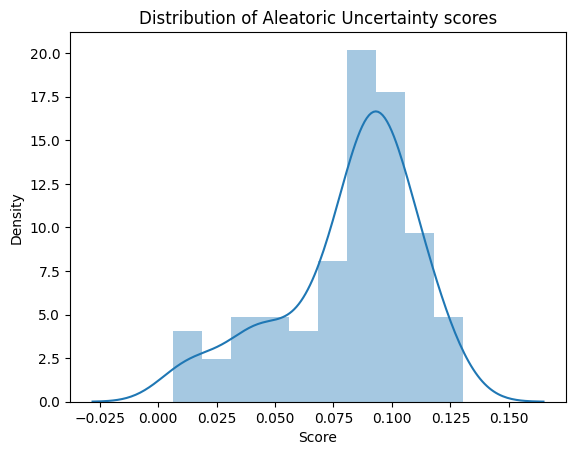

In [8]:
print(hcm.score_names)
hcm.plot_scores(axis=1)

Finally the `extract_datapoints` method can be used to select data based on the hcm score. Available methods for extract include `"top_n"`, `"threshold"` and `"index"`. Give them all a go!

The following cell takes the hardest 10 data points summarises them in a `pandas.DataFrame`.

[2023-07-24T14:45:04.532444+0100][19092][INFO] Sorting extracted datapoints
[2023-07-24T14:45:04.533156+0100][19092][INFO] [55]
[2023-07-24T14:45:04.533594+0100][19092][INFO] [55]


,indices,labels,scores
0,55,2,0.006556


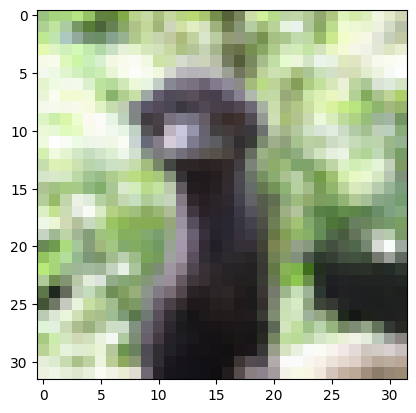

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
hardest_image = hcm.extract_datapoints(method="top_n", n=1)
display(pd.DataFrame(
    data={
        "indices":hardest_image[0][2],
        "labels": hardest_image[0][1],
        "scores": hardest_image[1]
    }
))
plt.imshow((hardest_image[0][0][0]/256).permute(1, 2, 0))

